In [32]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.svm import SVC, SVR 
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
cd /Users/pwalesdi/Desktop/GA/NBA_Player_Prediction/Notebooks/

/Users/pwalesdi/Desktop/GA/NBA_Player_Prediction/Notebooks


In [96]:
%store -r nba
%store -r first_second_seasons_agg

In [99]:
first_second_seasons_agg.shape

(621, 41)

In [120]:
# Creating a data set to do future predictions that can't be completely tested
test_master_agg = first_second_seasons_agg.loc[(first_second_seasons_agg['DRAFT_YEAR+1'] == 2017) | (first_second_seasons_agg['DRAFT_YEAR+1'] == 2018) | (first_second_seasons_agg['DRAFT_YEAR+1'] == 2016)]
test_master_agg.head(3)

,Player_name,player_id,Tm_x,DRAFT_YEAR+1,Draft_team,Pk,Pos,Age,College,Yrs,draft_round,target,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,BPM,FG%,3P%,FT%,PPG,RPG,APG,G,MP,VORP,PTS,TRB,AST,WS
0,A.J. Hammons,hammoaj01,DAL,2017.0,DAL,46.0,C,24,Purdue University,1.0,2.0,0,8.4,0.472,0.238,0.476,5.4,21.0,12.8,3.8,0.3,7.2,16.4,17.6,-0.001,-7.5,2.0,-5.6,0.405,0.500,0.450,2.2,1.6,0.2,22,163,-0.1,48.0,36.0,4.0,0.0
6,Abdel Nader,naderab01,BOS,2017.0,BOS,58.0,SF,24,Iowa State University,2.0,2.0,0,5.1,0.439,0.436,0.262,2.8,12.0,7.4,7.1,1.4,1.6,17.0,17.1,-0.014,-5.9,0.3,-5.6,0.387,0.333,0.667,3.6,1.7,0.4,48,522,-0.5,387.0,187.0,46.0,-0.1
15,Alec Peters,peteral01,PHO,2018.0,PHO,54.0,PF,22,Valparaiso University,1.0,2.0,0,10.7,0.523,0.784,0.135,3.7,14.0,8.8,7.9,0.4,0.7,4.9,15.5,0.055,-0.2,-3.1,-3.3,0.378,0.310,0.800,4.1,1.9,0.6,20,225,-0.1,82.0,37.0,12.0,0.3


In [36]:
first_second_seasons_agg_test = first_second_seasons_agg.loc[~first_second_seasons_agg["player_id"].isin(test_master_agg['player_id'])]
first_second_seasons_agg_test.sort_values("DRAFT_YEAR+1", ascending=False).shape

(475, 41)

In [139]:
features = [
            'Pk', 
            'Age', 
            'G', 
            'MP', 
            'TS%', 
            '3PAr', 
            'FTr', 
            'ORB%', 
            'DRB%', 
            'TRB%', 
            'AST%', 
            'BLK%', 
            'TOV%', 
            'USG%', 
            'WS', 
            'WS/48', 
            'OBPM', 
            'DBPM', 
            'BPM', 
            'VORP',
            'RPG',
            'PPG',
            'APG',
            'FT%',
            '3P%',
            'PER'
]

In [140]:
y = first_second_seasons_agg['target'] # Setting y --> our target variable
X = first_second_seasons_agg[features] # Creating our X variables based on the features we want to use to predict target
ss = StandardScaler() # Instantiate a standard scalar
X_sc = ss.fit_transform(X) # Fit and transform our X variable
ros = RandomOverSampler(random_state=0) # Instantiate a random oversampler in order to oversample our training set
X_resampled, y_resampled = ros.fit_resample(X_sc, y) # Fit that oversampler to our X_sc (scaled) and y data
print(sorted(Counter(y_resampled).items())) # Show the balance btw classes
# Train, test, split based on our oversampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=100, test_size=0.25)
X.shape

[(0, 579), (1, 579)]


(621, 26)

In [141]:
# Instantiating all of our different classification models
lr_class = LogisticRegression(penalty='l1', C=40, solver='liblinear')
knn_class = KNeighborsClassifier(n_neighbors=3, p=4, leaf_size=10)
tree_class = DecisionTreeClassifier(max_features='auto', min_samples_leaf=3, min_samples_split=4, random_state=100)
bag_class = BaggingClassifier(bootstrap=False, max_features=8, max_samples=100, n_estimators=100, random_state=100)
forest_class = RandomForestClassifier(bootstrap=True, max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=8, n_estimators=9, random_state=100)
ada_class = AdaBoostClassifier(learning_rate=0.78, n_estimators=100, random_state=100)
svc = SVC(degree=8, C=1, gamma=1, kernel='rbf', random_state=100)
grad_class = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3, min_samples_split=8, max_depth=3)

In [142]:
class_models = {
            'lr_class': lr_class, 
            'forest_class': forest_class, 
            'tree_class': tree_class,
            'ada_class': ada_class,            
            'knn_class': knn_class, 
            'bag_class': bag_class, 
            'svc': svc,
            "grad": grad_class
                } 

In [143]:
y_pred_testc = []
y_pred_trainc = []

for model in class_models.values():
    model.fit(X_train, y_train)
    y_pred_testc.append(model.predict(X_test))
    y_pred_trainc.append(model.predict(X_train))

y_pred_testc_df = pd.DataFrame(y_pred_testc, index=class_models.keys()).T
y_pred_trainc_df = pd.DataFrame(y_pred_trainc, index=class_models.keys()).T
print(y_pred_testc_df.shape)
print(y_pred_trainc_df.shape)

(290, 8)
(868, 8)


In [144]:
accuracy = {'train': [], 'test': [], 'F1-train': [], 'F1-test': [], 'true_neg': [], 'fal_pos': [], 'fal_neg': [], 'true_po': []}
for model in class_models.values():
    accuracy['train'].append(model.score(X_train, y_train))
    accuracy['test'].append(model.score(X_test, y_test))
for col in y_pred_testc_df:
    accuracy['F1-train'].append(f1_score(y_train, y_pred_trainc_df[col]))
    accuracy['F1-test'].append(f1_score(y_test, y_pred_testc_df[col]))
for col in y_pred_testc_df:
    accuracy['true_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][0])
    accuracy['fal_pos'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][1])
    accuracy['fal_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][0])
    accuracy['true_po'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][1])
    
accuracy_df = pd.DataFrame(accuracy, index=class_models.keys())
accuracy_df

,train,test,F1-train,F1-test,true_neg,fal_pos,fal_neg,true_po
lr_class,0.918203,0.893103,0.920135,0.888889,135,19,12,124
forest_class,0.994240,0.975862,0.994388,0.974910,147,7,0,136
tree_class,0.991935,0.958621,0.992161,0.957746,142,12,0,136
ada_class,1.000000,0.982759,1.000000,0.981949,149,5,0,136
knn_class,0.971198,0.944828,0.972558,0.944444,138,16,0,136
bag_class,0.944700,0.934483,0.948608,0.934708,135,19,0,136
svc,1.000000,1.000000,1.000000,1.000000,154,0,0,136
grad,1.000000,0.975862,1.000000,0.974910,147,7,0,136


In [145]:
master = test_master_agg[features]
master_sc = ss.fit_transform(master)
predicted_player = pd.DataFrame(index=master.index)
predicted_player[['Player_name', 'DRAFT_YEAR+1']] = test_master_agg[['Player_name', 'DRAFT_YEAR+1']]
for (model_name, model) in class_models.items():
    predicted_player[model_name] = model.predict(master_sc)
predicted_player['tot'] = predicted_player['lr_class'] + predicted_player['forest_class'] + predicted_player['tree_class'] + predicted_player['ada_class'] + predicted_player['knn_class'] + predicted_player['bag_class'] + predicted_player['svc'] + predicted_player['grad'] 
# predicted_player.to_csv('predict_15_16_17_based_on_2nd_yr')

In [13]:
%store predicted_player

Stored 'predicted_player' (DataFrame)


In [46]:
predicted_player.sort_values(by='tot', ascending=False)

,Player_name,DRAFT_YEAR+1,lr_class,forest_class,tree_class,ada_class,knn_class,bag_class,svc,grad,tot
438,Montrezl Harrell,2016.0,1,1,1,1,1,1,1,1,8
363,Kristaps Porzingis,2016.0,1,1,1,1,1,1,1,1,8
495,Richaun Holmes,2016.0,1,1,0,1,1,1,1,1,7
147,Devin Booker,2016.0,1,1,1,0,1,1,1,1,7
271,Jayson Tatum,2018.0,1,1,1,1,0,1,0,1,6
124,De'Aaron Fox,2018.0,1,0,0,1,1,1,0,1,5
160,Donovan Mitchell,2018.0,1,1,1,1,0,1,0,0,5
610,Willie Cauley-Stein,2016.0,1,1,1,0,0,1,0,1,5
43,Ben Simmons,2017.0,1,1,0,1,0,1,0,1,5
265,Jarrett Allen,2018.0,1,1,0,1,1,1,0,0,5


In [15]:
params = {
#     'max_depth' : [3, 4],
#     'min_samples_leaf' : [2, 3],
#     'min_samples_split' : [6, 7, 8],
#     'n_estimators' : [30, 35, 37],
#     "learning_rate" : (np.logspace(-1.6, -1, 20))
    'C' : np.logspace(-3, 3, 7),
    'gamma' : np.logspace(-3, 3, 7)
}
gs = GridSearchCV(
    SVC(),
    params,
    cv=3,
    verbose=1,
    return_train_score=False,
    n_jobs=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print()
print(gs.best_params_)
print()
print(gs.score(X_test, y_test))
pred = model.predict(X_test)
f1_score(y_test, pred)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


1.0

{'C': 1.0, 'gamma': 1.0}

1.0


[Parallel(n_jobs=2)]: Done 147 out of 147 | elapsed:    3.5s finished


0.9679715302491103

In [173]:
model = Sequential()
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])
#######

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > .999:
            self.model.stop_training=True

earlystop = myCallback()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.3, min_lr=0.00000001, verbose=1)

epochs=200
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(
#     optimizer="adam",
    optimizer=Adam(lr=0.003),
    loss="binary_crossentropy",
    metrics=["acc", f1])

history = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks = [reduce_lr, earlystop],
#     verbose=0,
)

Train on 868 samples, validate on 290 samples
Epoch 1/200
868/868 [==============================] - 3s 3ms/step - loss: 0.6768 - acc: 0.5910 - f1: 0.6111 - val_loss: 0.5099 - val_acc: 0.8310 - val_f1: 0.8462
Epoch 2/200
868/868 [==============================] - 0s 62us/step - loss: 0.5274 - acc: 0.7684 - f1: 0.7914 - val_loss: 0.3452 - val_acc: 0.8724 - val_f1: 0.8767
Epoch 3/200
868/868 [==============================] - 0s 75us/step - loss: 0.4204 - acc: 0.8168 - f1: 0.8206 - val_loss: 0.2691 - val_acc: 0.8724 - val_f1: 0.8732
Epoch 4/200
868/868 [==============================] - 0s 81us/step - loss: 0.3497 - acc: 0.8491 - f1: 0.8533 - val_loss: 0.2450 - val_acc: 0.8862 - val_f1: 0.8906
Epoch 5/200
868/868 [==============================] - 0s 75us/step - loss: 0.3191 - acc: 0.8859 - f1: 0.8948 - val_loss: 0.2194 - val_acc: 0.9241 - val_f1: 0.9239
Epoch 6/200
868/868 [==============================] - 0s 62us/step - loss: 0.2768 - acc: 0.8894 - f1: 0.8947 - val_loss: 0.2067 - val_

868/868 [==============================] - 0s 66us/step - loss: 0.1293 - acc: 0.9689 - f1: 0.9703 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 46/200
868/868 [==============================] - 0s 65us/step - loss: 0.1045 - acc: 0.9724 - f1: 0.9735 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-08.
Epoch 47/200
868/868 [==============================] - 0s 68us/step - loss: 0.1347 - acc: 0.9608 - f1: 0.9612 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 48/200
868/868 [==============================] - 0s 62us/step - loss: 0.1318 - acc: 0.9677 - f1: 0.9692 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 49/200
868/868 [==============================] - 0s 65us/step - loss: 0.1122 - acc: 0.9700 - f1: 0.9708 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 50/200
868/868 [==============================] - 0s 61us/step - loss: 0.1209 - acc: 0.9666 - f1: 0.9686 - val_loss: 

868/868 [==============================] - 0s 56us/step - loss: 0.1056 - acc: 0.9677 - f1: 0.9691 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 95/200
868/868 [==============================] - 0s 59us/step - loss: 0.1115 - acc: 0.9712 - f1: 0.9723 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 96/200
868/868 [==============================] - 0s 83us/step - loss: 0.1204 - acc: 0.9666 - f1: 0.9678 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 97/200
868/868 [==============================] - 0s 62us/step - loss: 0.1075 - acc: 0.9689 - f1: 0.9700 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 98/200
868/868 [==============================] - 0s 68us/step - loss: 0.1290 - acc: 0.9700 - f1: 0.9710 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 99/200
868/868 [==============================] - 0s 62us/step - loss: 0.1185 - acc: 0.9677 - f1: 0.9691 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 100/200
868/868 [

868/868 [==============================] - 0s 65us/step - loss: 0.1060 - acc: 0.9712 - f1: 0.9718 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 144/200
868/868 [==============================] - 0s 58us/step - loss: 0.1129 - acc: 0.9654 - f1: 0.9668 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 145/200
868/868 [==============================] - 0s 63us/step - loss: 0.1116 - acc: 0.9654 - f1: 0.9663 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 146/200
868/868 [==============================] - 0s 69us/step - loss: 0.1308 - acc: 0.9654 - f1: 0.9666 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 147/200
868/868 [==============================] - 0s 60us/step - loss: 0.1233 - acc: 0.9654 - f1: 0.9673 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 148/200
868/868 [==============================] - 0s 55us/step - loss: 0.1110 - acc: 0.9747 - f1: 0.9755 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 149/200
868/

868/868 [==============================] - 0s 52us/step - loss: 0.1356 - acc: 0.9654 - f1: 0.9677 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 193/200
868/868 [==============================] - 0s 57us/step - loss: 0.1174 - acc: 0.9712 - f1: 0.9715 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 194/200
868/868 [==============================] - 0s 55us/step - loss: 0.1210 - acc: 0.9631 - f1: 0.9639 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 195/200
868/868 [==============================] - 0s 59us/step - loss: 0.1264 - acc: 0.9597 - f1: 0.9615 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 196/200
868/868 [==============================] - 0s 60us/step - loss: 0.1094 - acc: 0.9666 - f1: 0.9679 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 197/200
868/868 [==============================] - 0s 90us/step - loss: 0.1178 - acc: 0.9677 - f1: 0.9682 - val_loss: 0.1011 - val_acc: 0.9621 - val_f1: 0.9600
Epoch 198/200
868/

In [174]:
confusion_matrix(y_test, model.predict_classes(X_test))

array([[143,  11],
       [  0, 136]])

In [175]:
master = test_master_agg[features]
master_nn = ss.fit_transform(master)
predicted_player_nn = pd.DataFrame(index=master.index)
predicted_player_nn[['Player_name', 'DRAFT_YEAR+1']] = test_master_agg[['Player_name', 'DRAFT_YEAR+1']]
predicted_player_nn['neural'] = model.predict_classes(master_nn)
predicted_player_nn.sort_values(by=['neural', "DRAFT_YEAR+1"], ascending=(False, False)).head(30)

,Player_name,DRAFT_YEAR+1,neural
40,Bam Adebayo,2018.0,1
124,De'Aaron Fox,2018.0,1
160,Donovan Mitchell,2018.0,1
265,Jarrett Allen,2018.0,1
271,Jayson Tatum,2018.0,1
365,Kyle Kuzma,2018.0,1
378,Lauri Markkanen,2018.0,1
43,Ben Simmons,2017.0,1
156,Domantas Sabonis,2017.0,1
248,Jamal Murray,2017.0,1


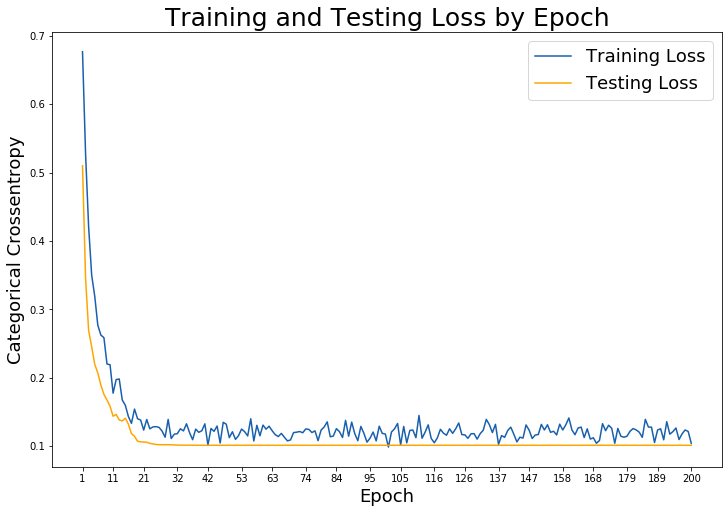

In [176]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

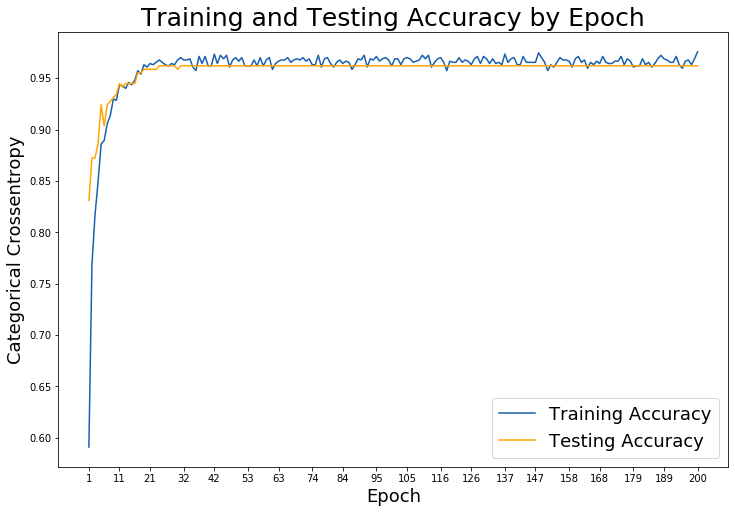

In [177]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

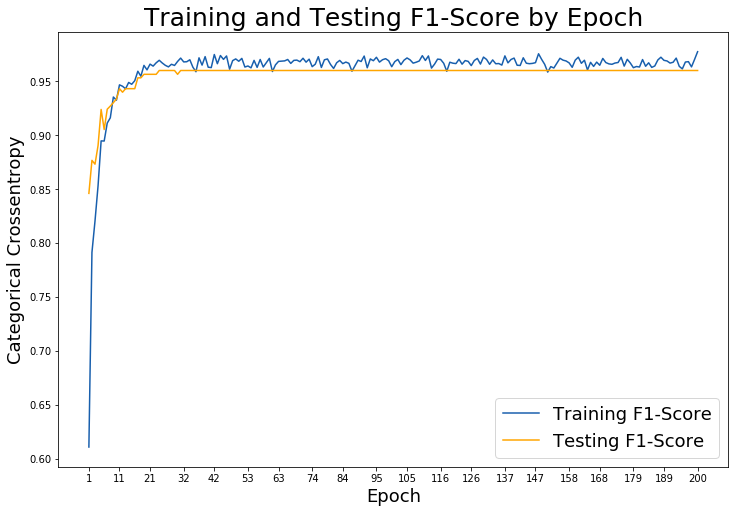

In [178]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['f1']
test_loss = history.history['val_f1']

# Set figure size.
plt.figure(figsize=(12, 8))

# Gaenerate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training F1-Score', color='#185fad')
plt.plot(test_loss, label='Testing F1-Score', color='orange')

# Set title
plt.title('Training and Testing F1-Score by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

In [179]:
test_master_w_predictions = pd.merge(test_master, predicted_player_nn, left_on='Player_name', right_on='Player_name')
test_master_w_predictions = pd.merge(test_master_w_predictions, predicted_player, left_on='Player_name', right_on='Player_name')
test_master_w_predictions.drop(columns=['lr_class', 'lr_class', 'tree_class', 'ada_class', 'knn_class', 'bag_class', 'svc', 'grad', 'forest_class', 'DRAFT_YEAR+1_x', 'DRAFT_YEAR+1_y'], inplace=True)
test_master_w_predictions.sort_values(by=['target','neural'], ascending=(False, False))

,Player_name,player_id,SEASON,Tm_x,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target,neural,DRAFT_YEAR+1,tot
82,Domantas Sabonis,sabondo01,2018,IND,ORL,11.0,C,21,74,1810,17.5,0.567,0.056,0.339,10.4,25.2,17.8,12.7,1.1,1.6,15.3,22.1,2.5,2.2,4.7,0.126,-0.8,0.5,-0.3,0.8,Gonzaga University,3.0,2383.0,1550.0,445.0,0.513,0.343,0.722,10.4,6.8,1.9,1.0,1,1,2017.0,6
94,Devin Booker,bookede01,2017,PHO,PHO,13.0,SG,20,78,2730,14.6,0.531,0.283,0.308,1.8,8.3,5.0,16.3,1.3,0.6,12.9,28.6,1.3,0.6,2.0,0.035,0.4,-2.7,-2.3,-0.2,University of Kentucky,4.0,5820.0,945.0,1154.0,0.437,0.354,0.854,21.4,3.5,4.2,1.0,1,1,2016.0,6
100,Montrezl Harrell,harremo01,2017,HOU,HOU,32.0,C,23,58,1064,19.2,0.662,0.020,0.351,8.3,14.2,11.2,9.6,0.9,3.2,9.9,17.6,3.1,1.0,4.1,0.183,0.8,0.2,0.9,0.8,University of Louisville,4.0,2864.0,1125.0,317.0,0.629,0.156,0.629,11.2,4.4,1.2,2.0,1,1,2016.0,7
106,Richaun Holmes,holmeri01,2017,PHI,PHI,37.0,C,23,57,1193,18.6,0.611,0.187,0.250,8.7,20.1,14.4,8.3,1.7,3.7,10.7,18.6,2.2,1.6,3.8,0.151,0.2,1.5,1.7,1.1,Bowling Green State University,4.0,1729.0,988.0,212.0,0.565,0.257,0.706,7.7,4.4,0.9,2.0,1,1,2016.0,7
120,Kristaps Porzingis,porzikr01,2017,NYK,NYK,4.0,PF,21,66,2164,17.4,0.546,0.319,0.256,5.5,18.2,11.8,7.3,1.1,4.9,9.7,24.3,2.4,2.1,4.5,0.100,0.2,0.0,0.2,1.2,NaN,3.0,3312.0,1317.0,248.0,0.437,0.361,0.804,17.8,7.1,1.3,1.0,1,1,2016.0,8
0,Bam Adebayo,adebaba01,2019,MIA,MIA,14.0,C,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,University of Kentucky,2.0,1206.0,978.0,285.0,0.550,0.136,0.728,8.0,6.5,1.9,1.0,0,1,2018.0,2
1,Jarrett Allen,allenja01,2019,BRK,BRK,22.0,C,20,80,2096,18.5,0.632,0.079,0.489,9.6,24.0,16.8,7.9,1.0,4.5,13.0,15.9,4.4,3.3,7.6,0.175,-0.7,3.2,2.5,2.4,University of Texas at Austin,2.0,1460.0,1060.0,159.0,0.590,0.183,0.732,9.6,7.0,1.0,1.0,0,1,2018.0,6
20,De'Aaron Fox,foxde01,2019,SAC,SAC,5.0,PG,21,81,2546,18.1,0.544,0.211,0.378,1.7,10.8,6.2,33.2,2.4,1.5,15.0,24.5,3.2,2.5,5.6,0.106,1.1,0.0,1.1,2.0,University of Kentucky,2.0,2243.0,508.0,910.0,0.439,0.345,0.725,14.6,3.3,5.9,1.0,0,1,2018.0,3
32,Kyle Kuzma,kuzmaky01,2019,LAL,BRK,27.0,PF,23,70,2314,14.0,0.546,0.388,0.230,2.7,14.1,8.5,11.5,0.8,0.9,10.0,23.8,1.2,1.9,3.1,0.065,-0.3,-1.3,-1.7,0.2,University of Utah,2.0,2550.0,865.0,319.0,0.453,0.335,0.731,17.3,5.9,2.2,1.0,0,1,2018.0,5
35,Lauri Markkanen,markkla01,2019,CHI,MIN,7.0,PF,21,52,1682,17.1,0.553,0.418,0.245,4.7,25.9,15.2,7.2,1.1,1.7,8.8,25.1,1.3,1.5,2.7,0.078,-0.3,-1.6,-1.9,0.0,University of Arizona,2.0,2007.0,978.0,154.0,0.432,0.362,0.859,16.7,8.2,1.3,1.0,0,1,2018.0,7


In [ ]:
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
             'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
             'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
             'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
             'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
             'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
             'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']



In [180]:
fig = px.scatter_3d(test_master_w_predictions, x='WS', y='VORP', z='MP',
            color='neural', 
            hover_name='Player_name', 
            hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], 
            symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# fig.update_layout(scene=dict(xaxis=dict(range=[-15,10],),))
fig.update_layout(legend_orientation="h")
fig.show()
plotly.offline.plot(fig, filename='html_files/aggregated_nn_ws_vorp_MP.html')

'html_files/aggregated_nn_ws_vorp_MP.html'

In [181]:
fig = px.scatter(test_master_w_predictions, x='VORP', y='WS',
            color='neural', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], 
#             color_continuous_scale='rdbu',
            symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
# fig.update_xaxes(range=[-2, 7])
fig.update_layout(legend_orientation="h")
fig.show()
plotly.offline.plot(fig, filename='html_files/aggregated_ws_vorp.html')

'html_files/aggregated_ws_vorp.html'

In [182]:
fig = px.scatter(test_master_w_predictions, x='TS%', y='USG%',
                 color='neural',
                 hover_name='Player_name',
                 hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age', 'RPG', 'VORP', 'WS'], 
                 color_continuous_scale=px.colors.diverging.PiYG,
                 symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(legend_orientation="h")
# fig.update_xaxes(range=[-2, 4.5])
fig.show()
plotly.offline.plot(fig, filename='html_files/aggregated_usg_ts%.html')

'html_files/aggregated_usg_ts%.html'

In [183]:
fig = px.scatter(test_master_w_predictions, x='OWS', y='DWS',
                 color='neural',
                 hover_name='Player_name',
                 hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age', 'RPG', 'VORP', 'WS'], 
                 color_continuous_scale=px.colors.diverging.RdBu,
                 symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(legend_orientation="h")
# fig.update_xaxes(range=[-2, 4.5])
fig.show()
plotly.offline.plot(fig, filename='html_files/aggregated_OWS_DWS.html')

'html_files/aggregated_OWS_DWS.html'

In [184]:
test_master_w_predictions.corr()[['tot', 'neural']].sort_values('neural', ascending=False)

,tot,neural
neural,0.827255,1.000000
tot,1.000000,0.827255
WS,0.641145,0.648498
PPG,0.598719,0.624230
OWS,0.616589,0.601110
PTS,0.586061,0.580487
VORP,0.537289,0.567751
RPG,0.683861,0.558142
MP,0.494084,0.547622
DWS,0.502906,0.538986
